# Processor Data Analysis

This document contains debugging and exploratory information based on data collected as part of the CODEX processor CLI (saved as ```processor_data.json```) and is often helpful for the following:
- Tracking large (and possibly erroneous) drift compensations
- Viewing best focal plane selections for each region and tile (often useful for finding bad parts of a sample)
- Diagnosing over/under saturation in individual channels
- Examining execution times by operation

### Parameters

In [1]:
# Parameters
processor_data_path = None

In [43]:
# Validation
assert processor_data_path is not None, 'Must set parameter for path to processor data json file'

### Load Processor Data

In [60]:
from codex.ops import op, best_focus, deconvolution, drift_compensation, tile_summary, tile_generator
from IPython import display
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

# Set expected keys for operations dynamically based on class names (to avoid
# future refactoring synchronization problems)
drift_comp_op = op.CodexOp.get_op_for_class(drift_compensation.CodexDriftCompensator)
best_focus_op = op.CodexOp.get_op_for_class(best_focus.CodexFocalPlaneSelector)
tile_summary_op = op.CodexOp.get_op_for_class(tile_summary.CodexTileSummary)
decon_op = op.CodexOp.get_op_for_class(deconvolution.CodexDeconvolution)
tile_gen_op = op.CodexOp.get_op_for_class(tile_generator.CodexTileGenerator)

# Load processor data as a dict of data frames, separated by operation type
with open(processor_data_path, 'r') as fd:
    data = json.load(fd)
    # Explicitly ignore tile generator stats
    data = {k: pd.DataFrame(v) for k, v in data.items() if k != tile_gen_op}

In [61]:
# Display the head rows for each operation type
for k in data:
    display.display(data[k].head().style.set_caption(k))

,mean_ratio,region,tile,tile_x,tile_y,time
0,1.01186,0,0,0,0,122.573
1,0.998502,0,0,0,0,122.573
2,1.00567,0,0,0,0,122.573
3,1.00245,0,0,0,0,122.573
4,1.0176,0,0,0,0,122.573


,region,target_cycle,tile,tile_x,tile_y,time,translation
0,0,1,0,0,0,58.1998,"[-2, 0]"
1,0,2,0,0,0,58.1998,"[-1, 0]"
2,0,3,0,0,0,58.1998,"[-2, -1]"
3,0,4,0,0,0,58.1998,"[0, -1]"
4,0,5,0,0,0,58.1998,"[-1, -1]"


,best_z,classifications,region,tile,tile_x,tile_y,time
0,5,"[10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,59.8497
1,5,"[10, 10, 6, 2, 1, 1, 1, 4, 10, 10, 10]",0,1,1,0,58.6365
2,5,"[10, 10, 10, 10, 4, 1, 1, 1, 2, 6, 10]",0,2,2,0,58.4432
3,5,"[10, 10, 8, 4, 1, 1, 1, 2, 6, 10, 10]",0,3,3,0,58.9546
4,5,"[10, 10, 10, 6, 2, 1, 1, 1, 4, 10, 10]",0,4,3,1,59.2869


,region,slice,tile,tile_x,tile_y,time
0,0,"['slice(71, 1976, None)', 'slice(71, 1976, None)']",0,0,0,3.90096e-05
1,0,"['slice(71, 1976, None)', 'slice(71, 1976, None)']",1,1,0,6.04649e-05
2,0,"['slice(71, 1976, None)', 'slice(71, 1976, None)']",2,2,0,6.77792e-05
3,0,"['slice(71, 1976, None)', 'slice(71, 1976, None)']",3,3,0,5.60763e-05
4,0,"['slice(71, 1976, None)', 'slice(71, 1976, None)']",4,3,1,3.90096e-05


,channel,max,mean,min,region,std,tile,tile_x,tile_y,time
0,HOECHST1,65535,1580.19,0,0,3169.69,0,0,0,20.622
1,CollagenIV,35737,567.927,1,0,535.497,0,0,0,20.622
2,CD7,32435,159.334,4,0,145.627,0,0,0,20.622
3,Ki67,50954,218.832,31,0,81.6967,0,0,0,20.622
4,HOECHST2,65535,1249.55,0,0,2531.14,0,0,0,20.622


### Drift Compensation Summary

Text(0.5,1,'Drift Compensation Translation by Region/Cycle')

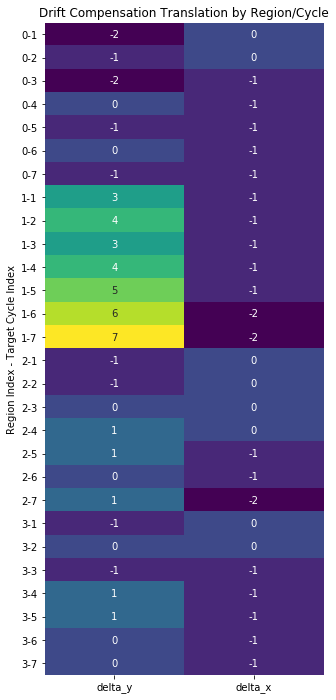

In [22]:
df = data[drift_comp_op].copy()
dims = ['z', 'y', 'x'][-len(df['translation'].iloc[0]):]
df = df.groupby(['region', 'target_cycle'])['translation'].first().reset_index()
for i, dim in enumerate(dims):
    df['delta_' + dim] = df['translation'].apply(lambda v: v[i])

sns.heatmap(
    df.set_index(['region', 'target_cycle']).drop('translation', axis=1),
    annot=True, cmap='viridis',
    yticklabels=1, cbar=False
)
plt.gcf().set_size_inches(5, 3 * df['region'].nunique())
plt.gca().set_ylabel('Region Index - Target Cycle Index')
plt.gca().set_title('Drift Compensation Translation by Region/Cycle')

### Focal Plane Summary

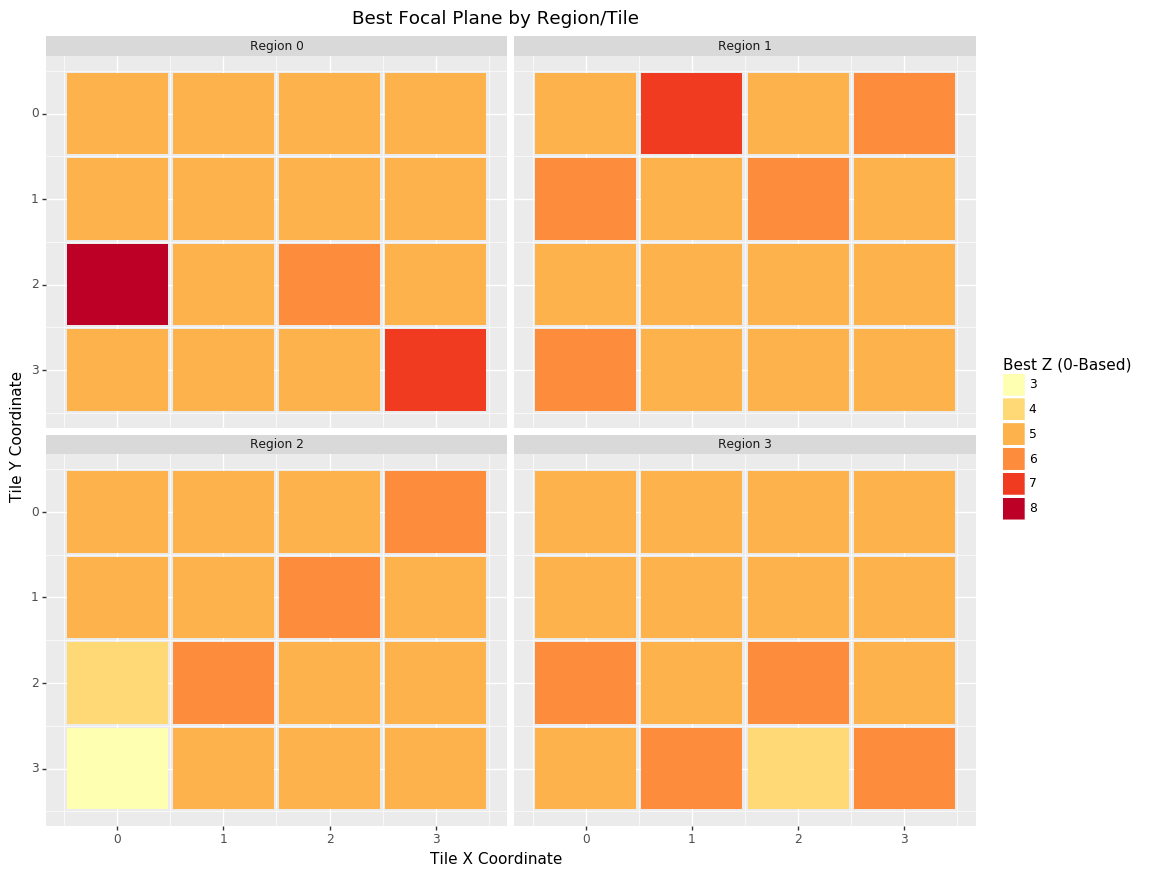

<ggplot: (-9223371909248011811)>

In [31]:
df = data[best_focus_op].copy()
(
    pn.ggplot(
        df.assign(
            z=df['best_z'].apply(lambda v: '{}'.format(v)),
            region_index=df['region'].apply(lambda v: 'Region {}'.format(v))
        ), 
        pn.aes(x='tile_x', y='tile_y', fill='z', width=.95, height=.95)
    ) +
    pn.scale_y_reverse() +
    pn.scale_fill_brewer(palette='YlOrRd', guide=pn.guide_legend(title='Best Z (0-Based)')) +
    pn.facet_wrap('~region_index', ncol=2) +
    pn.geom_tile() + 
    pn.xlab('Tile X Coordinate') +
    pn.ylab('Tile Y Coordinate') +
    pn.ggtitle('Best Focal Plane by Region/Tile') +
    pn.theme(figure_size=(12, 4 * (df['region'].nunique() + 1) // 2))
)

### Tile Summary Statistics

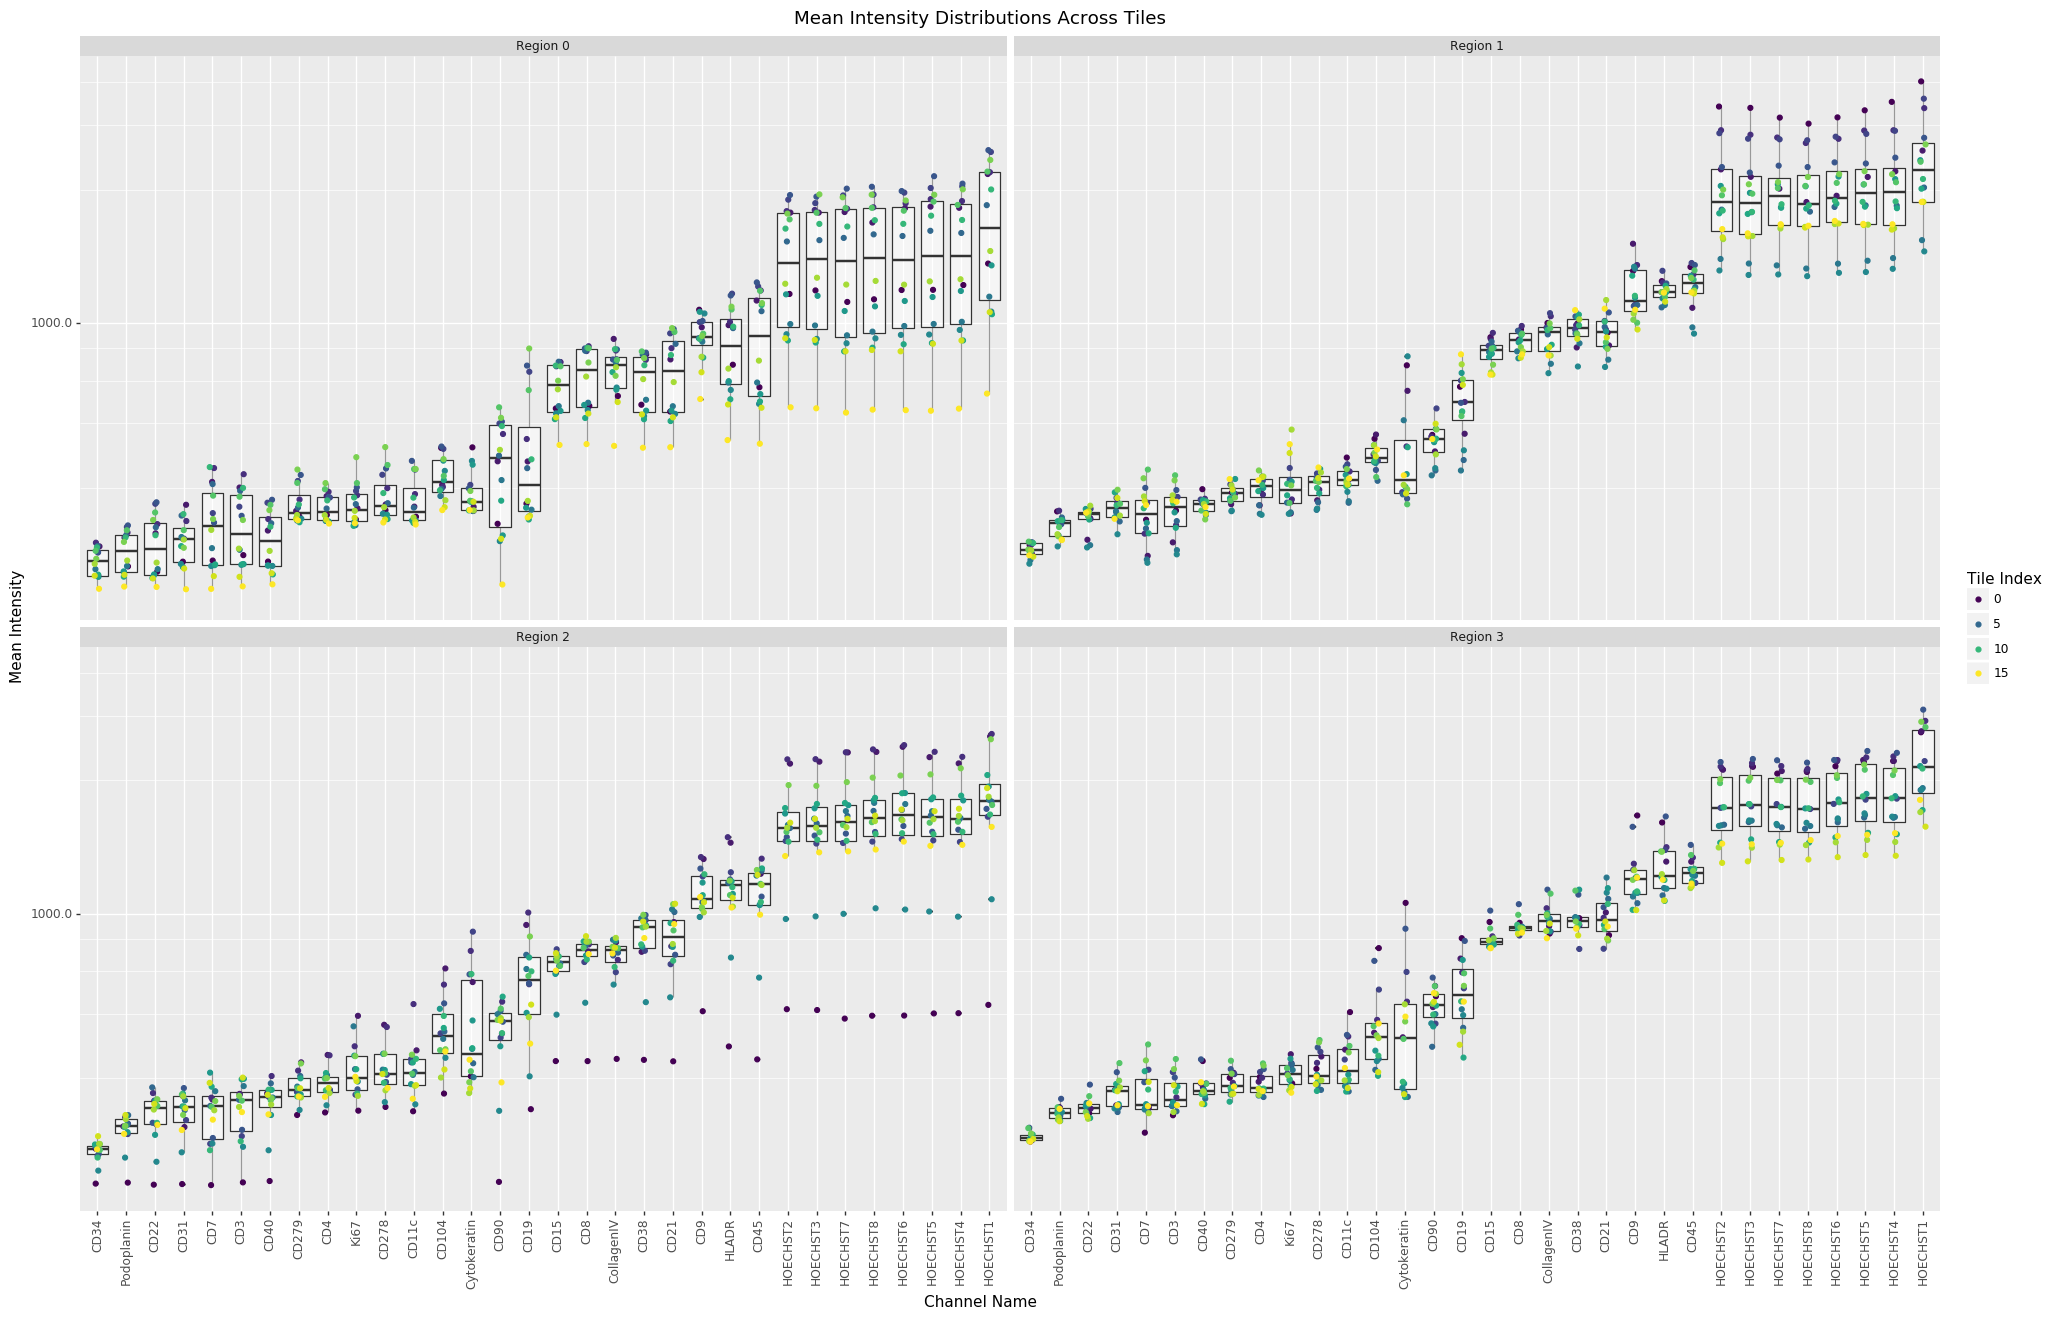

<ggplot: (127607091341)>

In [34]:
df = data[tile_summary_op].copy()
(
    pn.ggplot(
        df.assign(
            region=df['region'].apply(lambda v: 'Region {}'.format(v)),
            channel=pd.Categorical(
                df['channel'],
                categories=df.groupby('channel')['mean'].mean().sort_values().index, ordered=True
            )
        ), 
        pn.aes(x='channel', y='mean')
    ) + 
    pn.geom_boxplot(outlier_size=0, alpha=.5) +
    pn.geom_jitter(pn.aes(color='tile'), width=.1) +
    pn.scale_y_log10() +
    pn.scale_color_continuous(guide=pn.guide_legend(title='Tile Index')) +
    pn.facet_wrap('~region', ncol=2) +
    pn.theme(figure_size=(24, 6 * (df['region'].nunique() + 1) // 2), axis_text_x=pn.element_text(rotation=90)) +
    pn.ggtitle('Mean Intensity Distributions Across Tiles') +
    pn.xlab('Channel Name') +
    pn.ylab('Mean Intensity')
)

### Execution Time Breakdown

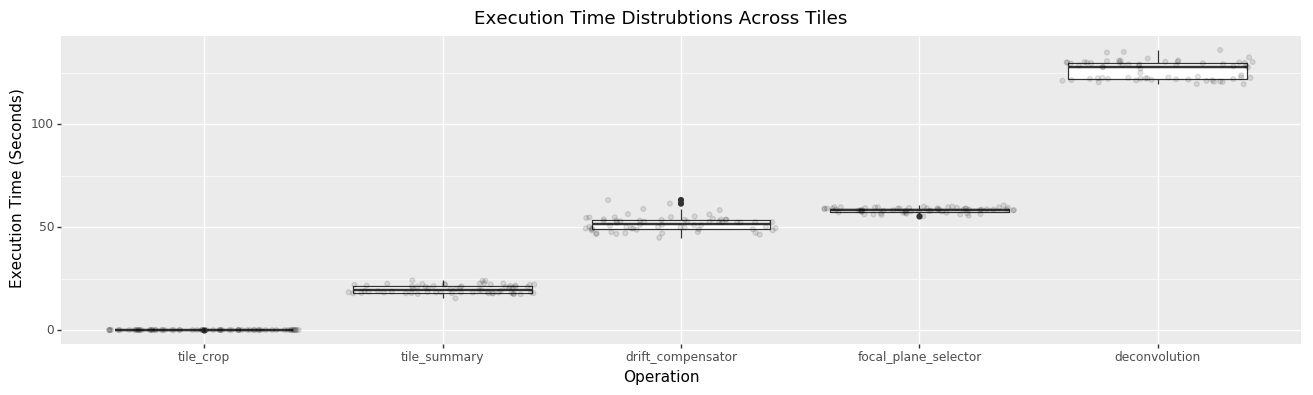

<ggplot: (-9223371909248216260)>

In [70]:
df = pd.concat(
    [data[k].groupby(['region', 'tile'])['time'].first().rename(k) for k in data.keys()],
    axis=1
)
df.columns.name = 'operation'
df = df.stack().rename('time').reset_index()
(
    pn.ggplot(
        df.assign(operation=pd.Categorical(
            df['operation'], 
            categories=df.groupby('operation')['time'].median().sort_values().index,
            ordered=True
        )),
        pn.aes(x='operation', y='time')
    ) +
    pn.geom_boxplot() +
    pn.geom_jitter(alpha=.1) +
    pn.xlab('Operation') + 
    pn.ylab('Execution Time (Seconds)') +
    pn.ggtitle('Execution Time Distrubtions Across Tiles') +
    pn.theme(figure_size=(16, 4))
)